<a href="https://colab.research.google.com/github/bmjaron/phase_4_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Business Understanding

# II. Data Understanding

## A. Data Collection and Description

We'll begin by importing necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

We'll now load the data and preview.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/bmjaron/phase_4_project/main/data.csv')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.shape

(8721, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

We can tell that we have data for 8,721 tweets that contain the text of the tweet, the brand or product that each given tweet is directed at, and whether or not the emotion expressed by the tweet is either positive or negative.

We also see that we have some instances of null values. In particular, there is one tweet that is missing the text. But what is more noteworthy is that we only have a little over 1/3 of the product/brand target of the tweet.  

## B. Exploratory Data Analysis

### **Are tweets generally positive or negative?**

We saw earlier that the emotions of our tweets can be broken down into 4 categories: 1) no emotion, 2) positive, 3) negative, 4) unable to determine emotion. Below, we'll visualize the break down.

<BarContainer object of 4 artists>

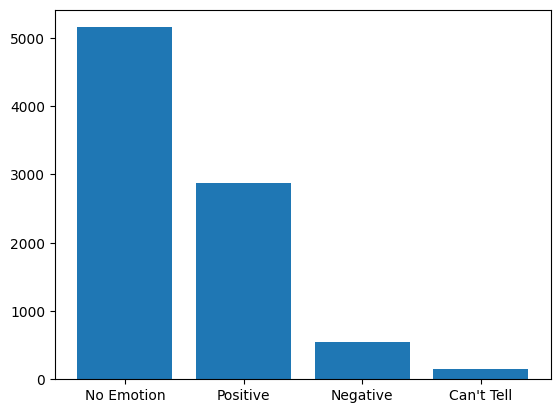

In [7]:
plt.bar(x=['No Emotion', 'Positive', 'Negative', "Can't Tell"],
        height=[df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()[n] for n in range(4)])


### **What is the emotion of tweet based on products/brands?**




In [8]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
map_dict = {'Apple': ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'],
            'Google': ['Google', 'Other Google product or service'],
            'Android': ['Android App', 'Android']}

df_2 = df.copy()
df_2 = df_2.dropna(axis=0)

df_2['emotion_in_tweet_is_directed_at'] = df_2['emotion_in_tweet_is_directed_at'].map(lambda x: 'Apple' if x in map_dict['Apple'] else (
                                                                                                'Google' if x in map_dict['Google'] else
                                                                                                'Android'))

df_2['emotion_in_tweet_is_directed_at'].value_counts()

Apple      2323
Google      694
Android     152
Name: emotion_in_tweet_is_directed_at, dtype: int64

IndexError: ignored

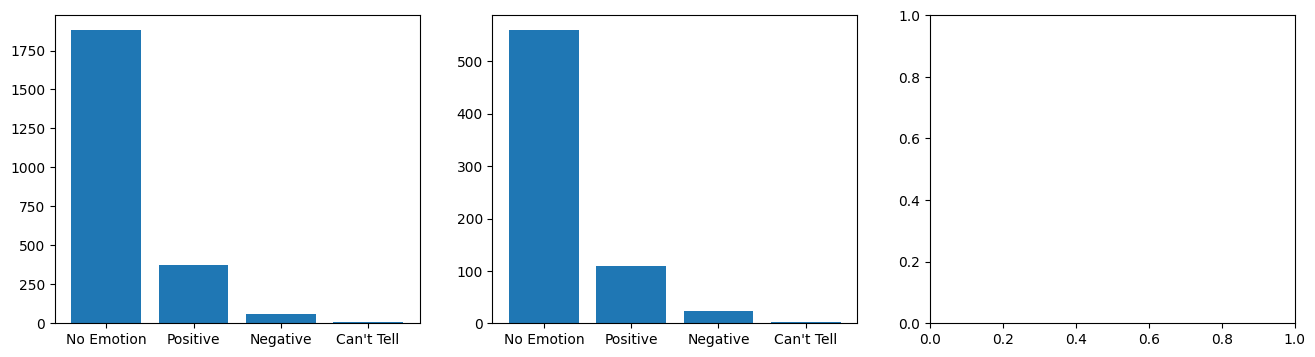

In [23]:
apple = df_2[df_2['emotion_in_tweet_is_directed_at'] == 'Apple']
google = df_2[df_2['emotion_in_tweet_is_directed_at'] == 'Google']
android = df_2[df_2['emotion_in_tweet_is_directed_at'] == 'Android']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for n, b in enumerate([apple, google, android]):
  axes[n].bar(x=['No Emotion', 'Positive', 'Negative', "Can't Tell"],
              height=[b['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()[x] for x in range(4)])

NameError: ignored

# III. Data Preparation